# tSNE

In [1]:
import os
from sklearn import manifold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
from pathlib import Path
path = str(Path(os.getcwd()).parent.parent)
sys.path.insert(0, path)
from breakout.vae.vae import ConvVAE

import_path = str(Path(os.getcwd()).parent.parent.parent)

sys.path.insert(0, import_path)

from WorldModelsExperiments.breakout.model import make_model, _process_frame

/home/dakaun/PycharmProjects/world_model/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dakaun/PycharmProjects/world_model/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dakaun/PycharmProjects/world_model/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dakaun/

In [3]:
num_actions = 4
    
gamename ='breakout'
optimizer = 'cma'
num_episode = 16
population = 32 # = num_workers * num_worker_trial
    
path = '/home/dakaun/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200420'
    
file_path = path + '/log/'
file_base = gamename+'.'+optimizer+'.'+str(num_episode)+'.'+str(population)
    
vae_path = path + '/tf_vae'
rnn_path = path + '/tf_rnn'
    
record = path + '/record'

In [4]:
model = make_model(rnn_path=os.path.join(rnn_path, 'rnn.json'), vae_path=os.path.join(vae_path, 'vae.json'))

model.load_model(os.path.join(file_path, file_base + '.best.json'))

INFO:tensorflow:Model using cpu.
loading file /home/dakaun/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200420/log/breakout.cma.16.32.best.json


In [ ]:
# run simulate several times to collect data

In [7]:
def simulate(model, train_mode=False, render_mode=True, num_episode=5, seed=-1, max_len=-1):
    reward_list = []
    t_list = []
    max_episode_length = 2100
    tsne_data = pd.DataFrame()    
    action_list = []#action_list_episode = []
    observation_list_episode = []
    reward_target = []
    
    if (seed >= 0):
        random.seed(seed)
        np.random.seed(seed)
        model.env.seed(seed)
    

    for episode in range(num_episode):
        #action_list = []
        observation_list = []
        obs = model.env.reset()
        if obs is None:
            obs = deepcopy(model.env.reset())
        #obs = _process_frame(obs)

        total_reward = 0.0

        for t in range(max_episode_length):
            if render_mode:
                model.env.render("human")
                model.env.unwrapped.viewer.window.on_key_press = key_press
                if RENDER_DELAY:
                    time.sleep(0.01)
            else:
                model.env.render('rgb_array')
            obs = _process_frame(obs)
            z, mu, logvar = model.encode_obs(obs)
            _, action = model.get_action(z)
            obs, reward, done, info = model.env.step(action)

            action_list.append(int(action))
            observation_list.append(obs)
            #obs = _process_frame(obs)
            total_reward += reward
            reward_target.append(int(reward))

            data = np.concatenate([z, model.state.h[0]]).reshape(1,288)
            #data = np.append(data, action).reshape(1,289)
            tsne_data = tsne_data.append(pd.DataFrame(data), ignore_index=True)

            if done:
                if render_mode:
                    model.env.close()
                #action_list_episode.append(np.array(action_list))
                observation_list_episode.append(observation_list)
                break
    if render_mode:
        print("reward", total_reward, "timesteps", t)
    reward_list.append(total_reward)
    t_list.append(t)
    return reward_list, t_list, action_list, np.array(observation_list_episode), tsne_data, reward_target


In [8]:
rewards, timesteps, actions, observations, tsne_data, reward_target = simulate(model, train_mode=False, render_mode=False, num_episode=10)

In [9]:
tsne_data.shape

(9759, 288)

## TSNE - Target: Actions

In [10]:
actions = np.array(actions)

In [60]:
actions

array([1, 1, 1, 1, 1, 1, ..., 1, 2, 2, 1, 2, 2])

In [11]:
actions.shape

(9759,)

In [12]:
tsne = manifold.TSNE(n_components= 2, init='random', random_state=0)

In [13]:
y_tsne = tsne.fit_transform(tsne_data)

In [14]:
y_tsne.shape

(9759, 2)

In [ ]:
y_tsne

In [55]:
y_tsne_1, y_tsne_2 = np.array_split(y_tsne, indices_or_sections=2, axis=1)

In [56]:
y_tsne_1.shape

(2522, 1)

In [ ]:
# https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_tsne.html

In [14]:
cut = 1.01
xmax = cut * max(y_tsne[:,0])
ymax = cut * max(y_tsne[:,1])
xmin = cut * min(y_tsne[:,0])
ymin = cut * min(y_tsne[:,1])

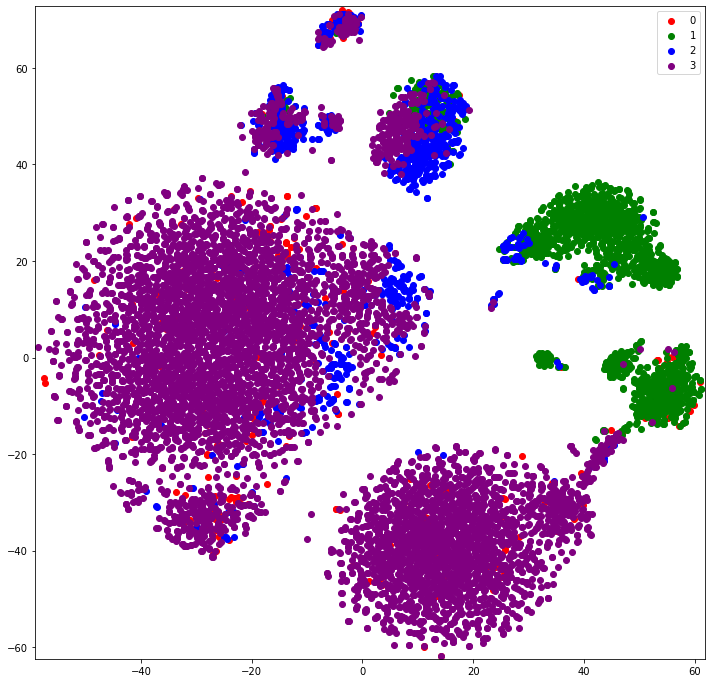

In [15]:
colors = 'r', 'g', 'b', 'purple'
target_ids = range(4)


plt.figure(figsize=(12,12))
for i, c in zip(target_ids, colors):
    plt.scatter(y_tsne[actions==i, 0], y_tsne[actions==i, 1], c=c, label =i)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()

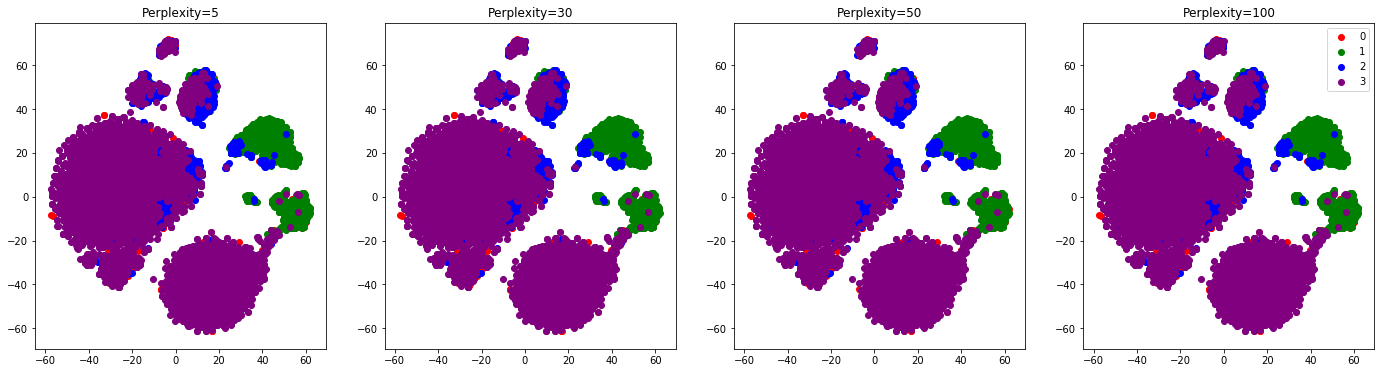

In [23]:
perplexities = [5, 30, 50, 100]
(fig, subplots) = plt.subplots(1,4, figsize=(24,6))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=perplexity)
    Y_tsne = tsne.fit_transform(tsne_data)
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(y_tsne[actions==0,0], y_tsne[actions==0,1], c='r', label=0)
    ax.scatter(y_tsne[actions==1,0], y_tsne[actions==1,1], c='g', label=1)
    ax.scatter(y_tsne[actions==2,0], y_tsne[actions==2,1], c='b', label=2)
    ax.scatter(y_tsne[actions==3,0], y_tsne[actions==3,1], c='purple', label=3)
plt.legend()
plt.show()

### Analysis of cluster and frames within cluster

#### pinkes cluster unten rechts

In [42]:
clu1 = np.where((y_tsne[:,0]>18) & (y_tsne[:,0]<21) & (y_tsne[:,1]<-38) & (y_tsne[:,1]>-41))[0].tolist()
#row1

In [43]:
len(clu1)

21

In [83]:
clu1_purp = [elem for elem in clu1 if actions[elem]==3]

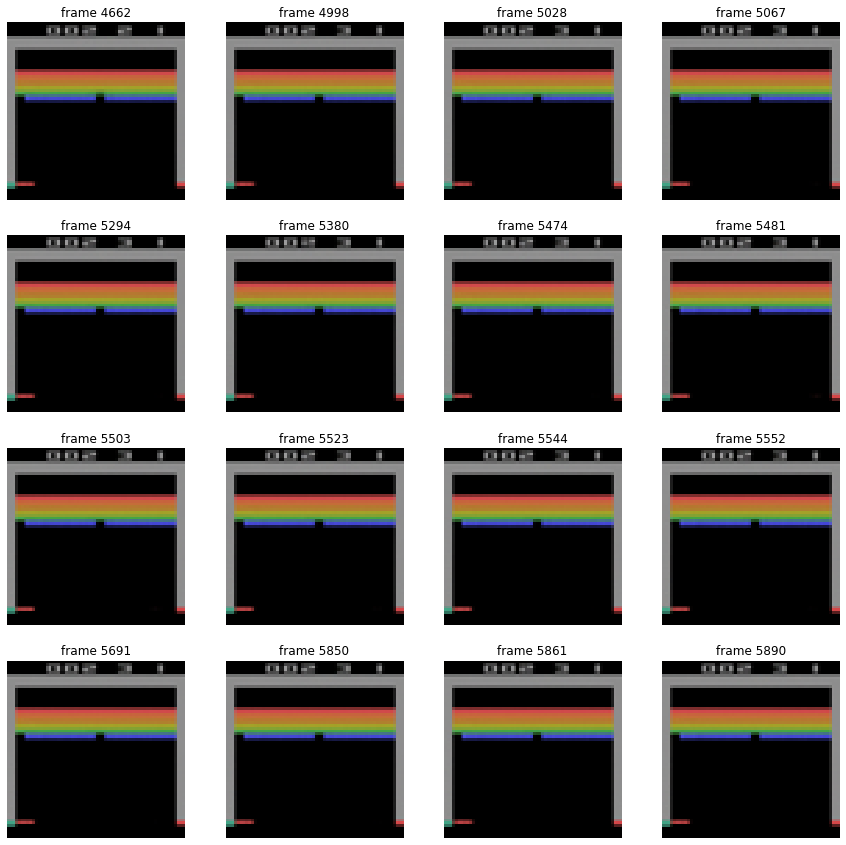

In [84]:
plt.figure(figsize=(15,15)) #todo target checken... 
for idx in range(16):
    plt.subplot(4,4, idx+1)
    #row1[idx] gibt index für ytsne und tsnedata (ersten 32 var sind für z)
    plt.title(f"frame {clu1_purp[idx]}")
    plt.imshow(model.vae.decode(np.array(tsne_data.iloc[clu1_purp[idx], 0:32]).reshape(1,32)).reshape(64,64,3))
    plt.axis('off')
    

#### grünes cluster mitte rechts

In [147]:
clu2 = np.where((y_tsne[:,0]>54) & (y_tsne[:,0]<57) & (y_tsne[:,1]<-3) & (y_tsne[:,1]>-8))[0].tolist()
len(clu2)

60

In [149]:
clu2_green = [elem for elem in clu2 if actions[elem]==1]
len(clu2_green)

56

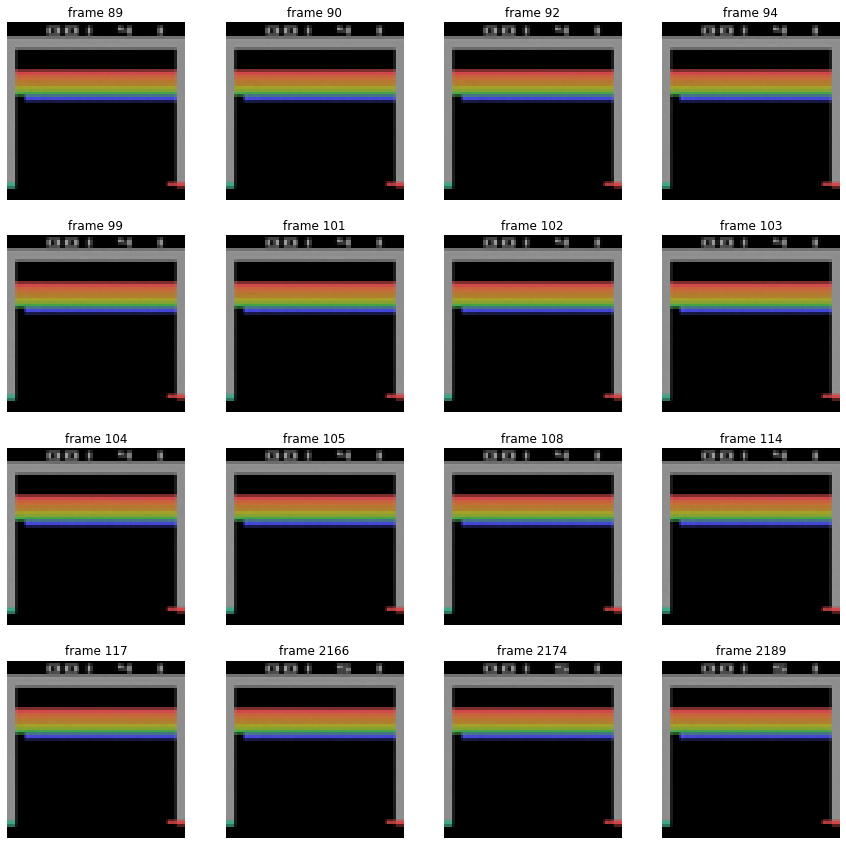

In [150]:
plt.figure(figsize=(15,15)) 
for idx in range(16):
    plt.subplot(4,4, idx+1)
    plt.title(f"frame {clu2_green[idx]}")
    plt.imshow(model.vae.decode(np.array(tsne_data.iloc[clu2_green[idx], 0:32]).reshape(1,32)).reshape(64,64,3))
    plt.axis('off')
    

#### grünes cluster rechts oben

In [156]:
clu3 = np.where((y_tsne[:,0]>41) & (y_tsne[:,0]<43) & (y_tsne[:,1]<29) & (y_tsne[:,1]>26))[0].tolist()
len(clu3)

19

In [157]:
clu3_green = [elem for elem in clu3 if actions[elem]==1]
len(clu3_green)

19

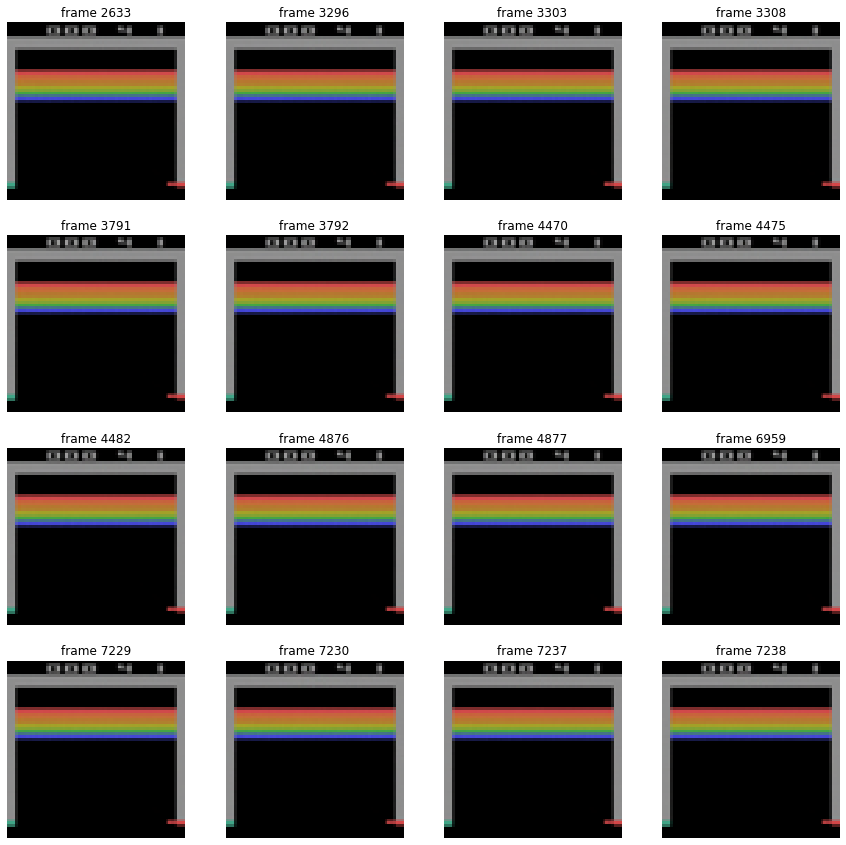

In [158]:
plt.figure(figsize=(15,15)) 
for idx in range(16):
    plt.subplot(4,4, idx+1)
    plt.title(f"frame {clu3_green[idx]}")
    plt.imshow(model.vae.decode(np.array(tsne_data.iloc[clu3_green[idx], 0:32]).reshape(1,32)).reshape(64,64,3))
    plt.axis('off')
    

#### blau/lila cluster oben (rechtes) - blau

In [164]:
clu4 = np.where((y_tsne[:,0]>12) & (y_tsne[:,0]<18) & (y_tsne[:,1]<50) & (y_tsne[:,1]>40))[0].tolist()
len(clu4)

126

In [165]:
clu4_blue = [elem for elem in clu4 if actions[elem]==2]
len(clu4_blue)

92

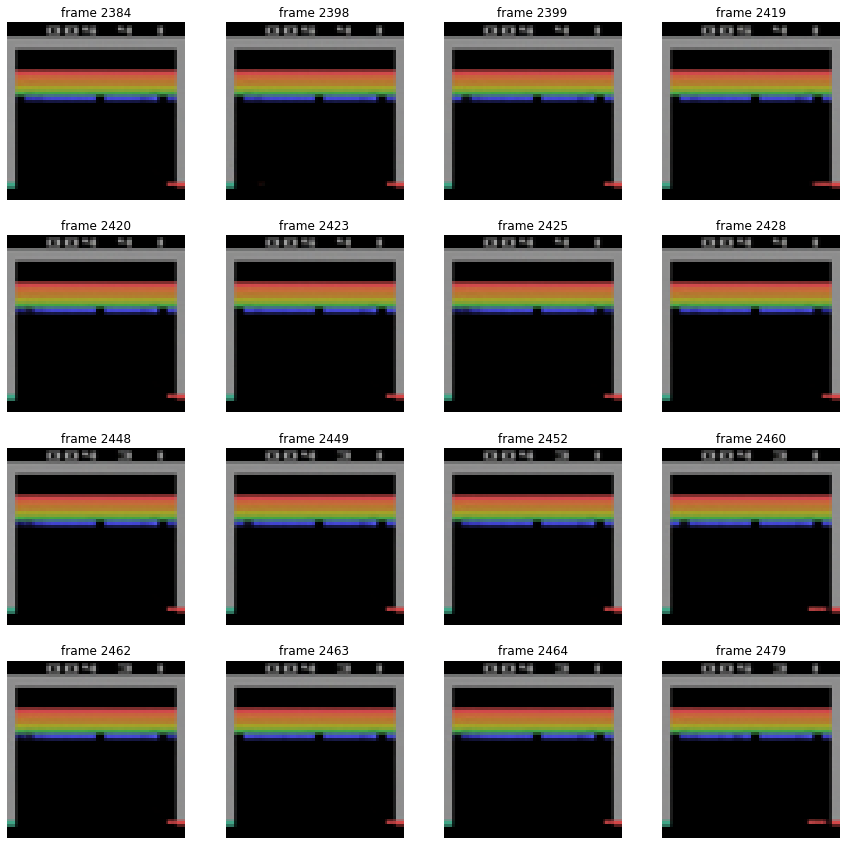

In [166]:
plt.figure(figsize=(15,15)) 
for idx in range(16):
    plt.subplot(4,4, idx+1)
    plt.title(f"frame {clu4_blue[idx]}")
    plt.imshow(model.vae.decode(np.array(tsne_data.iloc[clu4_blue[idx], 0:32]).reshape(1,32)).reshape(64,64,3))
    plt.axis('off')

## TSNE - Target: Reward

In [16]:
reward_target = np.array(reward_target)

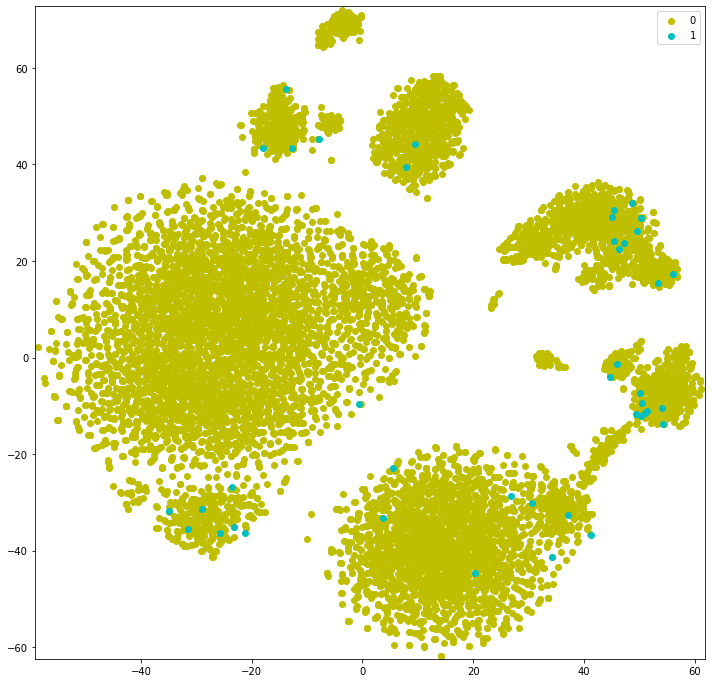

In [17]:
colors = 'y', 'c' # 
target_ids = range(2)


plt.figure(figsize=(12,12))
for i, c in zip(target_ids, colors):
    plt.scatter(y_tsne[reward_target==i, 0], y_tsne[reward_target==i, 1], c=c, label =i)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()